In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

## Load data

In [3]:
train_X = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/X_train.pkl').sort_index()
train_y = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/y_train.pkl').sort_index()['Redox_error_flag']
test_X = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/X_test.pkl').sort_index()
test_y = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/y_test.pkl').sort_index()['Redox_error_flag']
test_2023 = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2023/test.pkl').sort_index()
pit_train_X = []
pit_train_y = []
pit_test_X = []
pit_test_y = []
pit_test_2023 = []
for d in range(1,6):
    pit_train_X.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/X_train_sensor_{d}.pkl').sort_index())
    pit_train_y.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/y_train_sensor_{d}.pkl').sort_index())
    pit_test_X.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/X_test_sensor_{d}.pkl').sort_index())
    pit_test_y.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/y_test_sensor_{d}.pkl').sort_index())
    pit_test_2023.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2023_sensors/test_sensor_{d}.pkl').sort_index())

## Filter unwanted columns for model training

In [11]:
dropped_features = [
    'TIMESTAMP', 
    'Redox_error_flag',
    'pit_number'
]
filtered_train_X = train_X.loc[:, ~train_X.columns.isin(dropped_features)]
filtered_test_X = test_X.loc[:, ~test_X.columns.isin(dropped_features)]
filtered_2023 = test_2023.loc[:, ~test_2023.columns.isin(dropped_features)]
filtered_pit_train_X = [df.loc[:, ~df.columns.isin(dropped_features)] for df in pit_train_X]
filtered_pit_test_X = [df.loc[:, ~df.columns.isin(dropped_features)] for df in pit_test_X]
filtered_pit_test_2023 = [df.loc[:, ~df.columns.isin(dropped_features)] for df in pit_test_2023]

## Parameter tuning
Models are scored using recall as the scoring metric as the default option, accuracy, doesn't introduce much separation between the models. Randomized search was used instead of grid search as the temporal cost of using grid search with this many possible parameter combinations would have been too high.

In [5]:
n_estimators = [25, 50, 100, 300, 500]
max_features = ['log2', 'sqrt', None]
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_leaf_nodes = [3, 6, 9, None]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Optimal parameters based on the randomized search

In [10]:
rand_search = RandomizedSearchCV(RandomForestClassifier(), param_grid, scoring='recall', n_jobs=-1)
rand_search.fit(filtered_train_X, train_y)
print(rand_search.best_estimator_)
print(rand_search.best_params_)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=25)
{'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


### Recall score of the best model

In [11]:
print(rand_search.best_score_)

0.7594281824370319


## Model training

In [12]:
rf = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=25)
rf.fit(filtered_train_X, train_y)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=25)

## Results

In all of the graphs, the blue lines represent the Redox potential averages and the red dots represent predicted anomalies. 

The results given by the random forest models are really poor overall, with very few predicted anomalies in the 2023 data. 

### Testing dataset (subset of 2022 data)

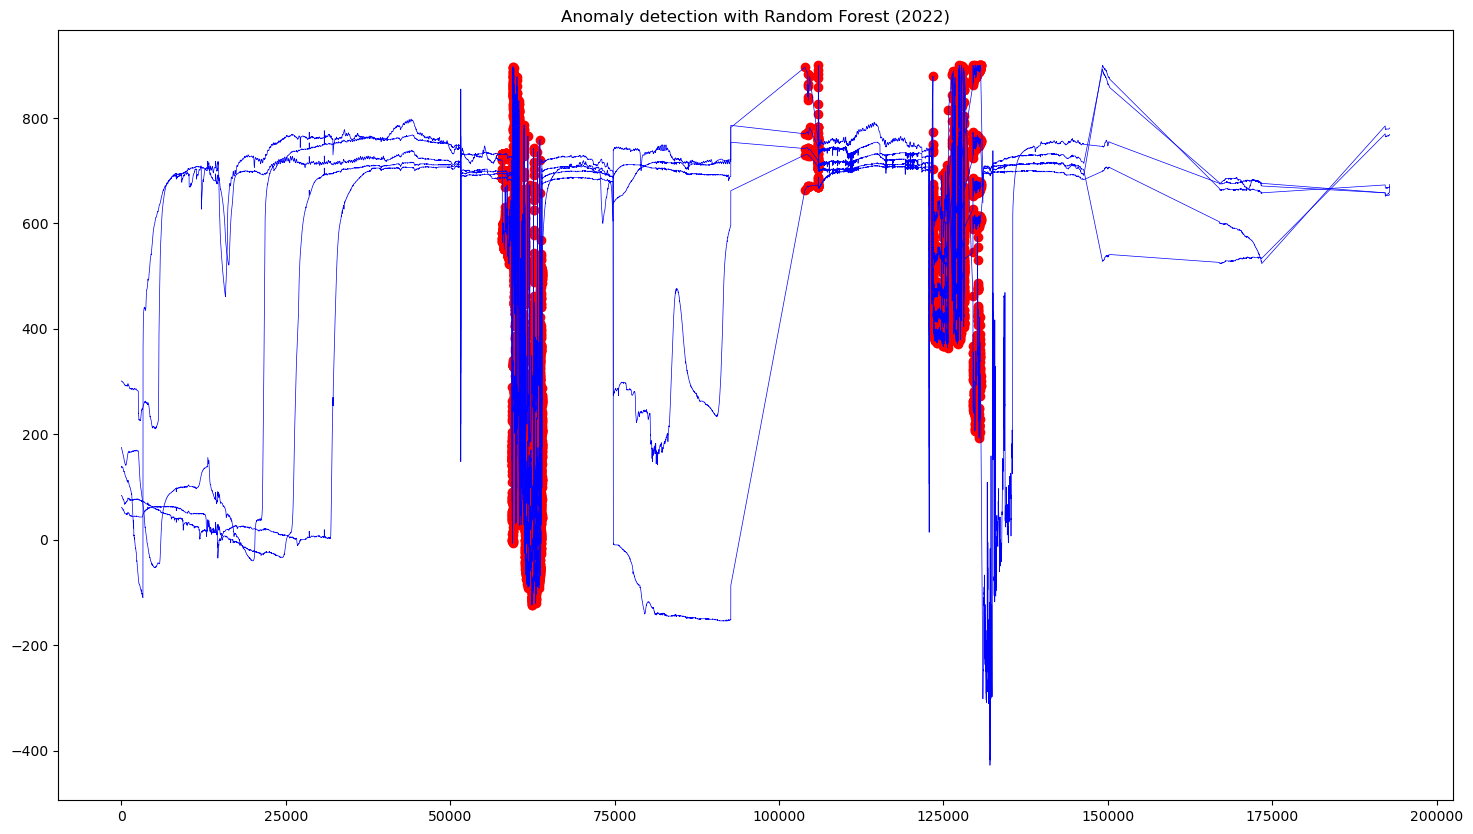

In [13]:
y_hat = rf.predict(filtered_test_X)
plt.figure(figsize=(18,10))
plt.plot(test_X.index, test_X[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
plt.scatter(test_X[y_hat == True].index, test_X[y_hat == True][f'Redox_Avg(1)'], c='r')
plt.scatter(test_X[y_hat == True].index, test_X[y_hat == True][f'Redox_Avg(2)'], c='r')
plt.scatter(test_X[y_hat == True].index, test_X[y_hat == True][f'Redox_Avg(3)'], c='r')
plt.scatter(test_X[y_hat == True].index, test_X[y_hat == True][f'Redox_Avg(4)'], c='r')
plt.scatter(test_X[y_hat == True].index, test_X[y_hat == True][f'Redox_Avg(5)'], c='r')
plt.title(f'Anomaly detection with Random Forest (2022)')
plt.show()

### 2023 predictions using all sensors

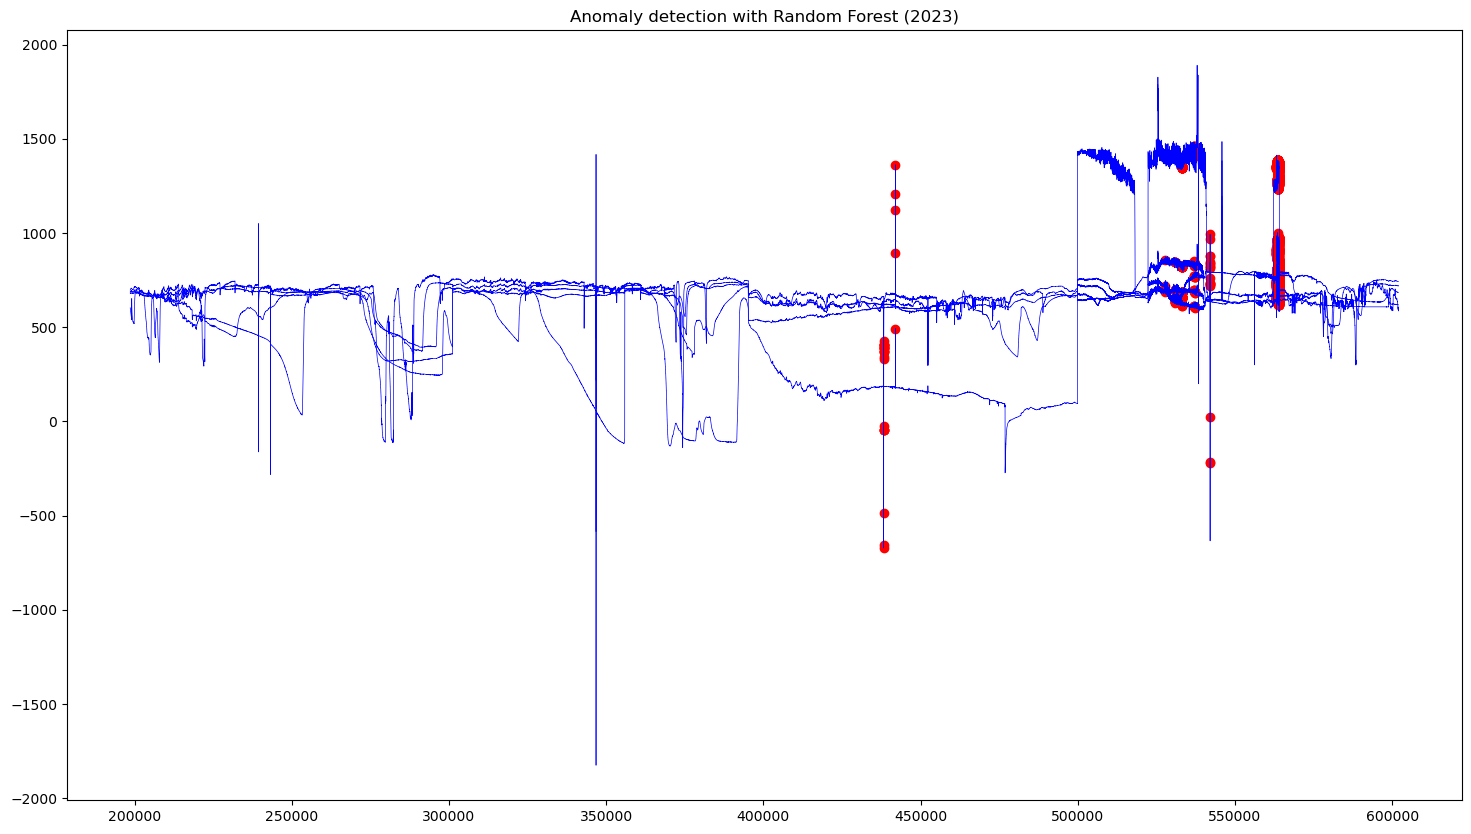

In [14]:
y_hat = rf.predict(filtered_2023)
plt.figure(figsize=(18,10))
plt.plot(test_2023.index, test_2023[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
plt.scatter(test_2023[y_hat == True].index, test_2023[y_hat == True][f'Redox_Avg(1)'], c='r')
plt.scatter(test_2023[y_hat == True].index, test_2023[y_hat == True][f'Redox_Avg(2)'], c='r')
plt.scatter(test_2023[y_hat == True].index, test_2023[y_hat == True][f'Redox_Avg(3)'], c='r')
plt.scatter(test_2023[y_hat == True].index, test_2023[y_hat == True][f'Redox_Avg(4)'], c='r')
plt.scatter(test_2023[y_hat == True].index, test_2023[y_hat == True][f'Redox_Avg(5)'], c='r')
plt.title(f'Anomaly detection with Random Forest (2023)')
plt.show()

### 2022 sensor-specific test datasets

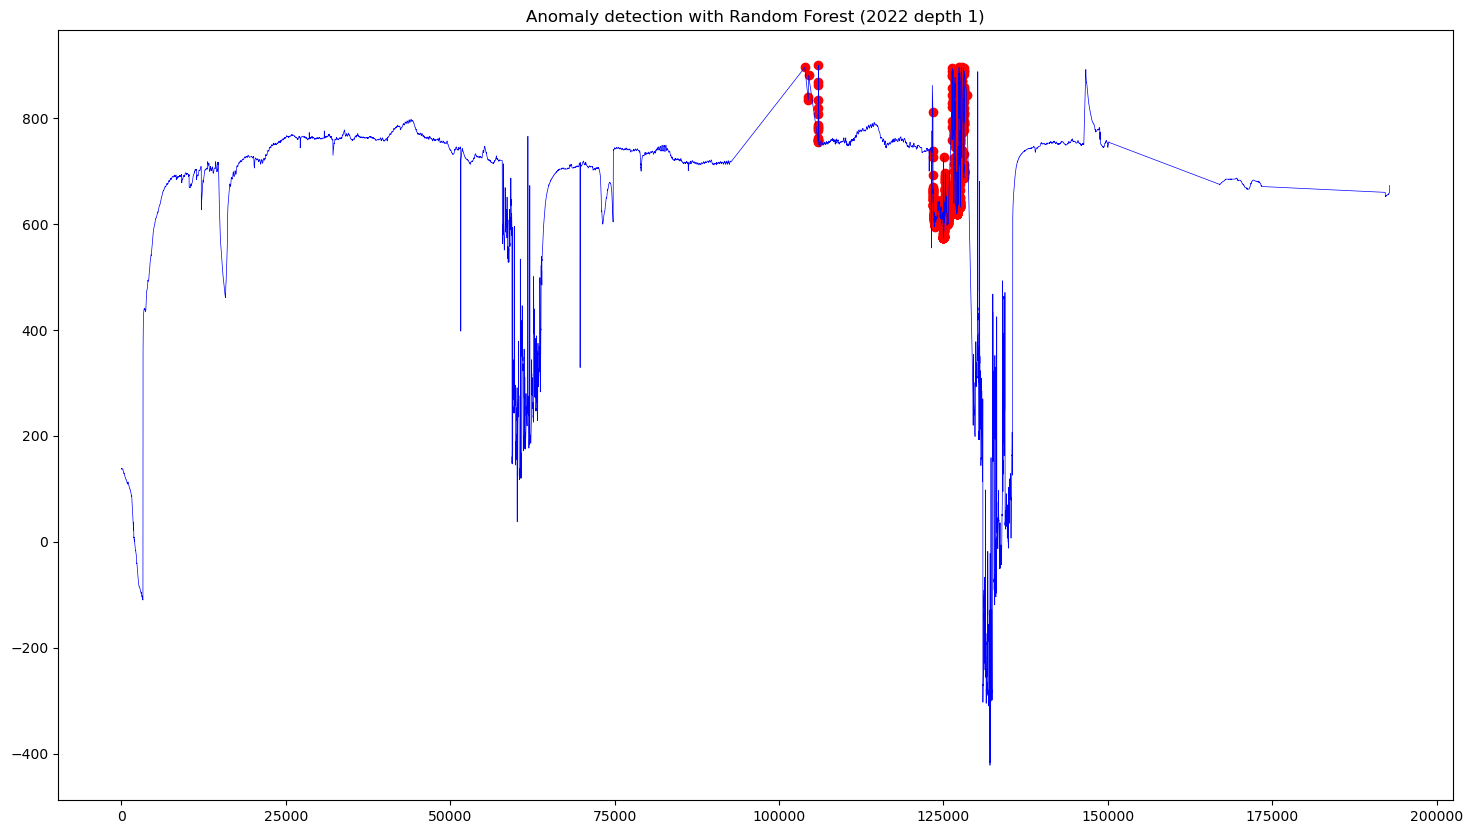

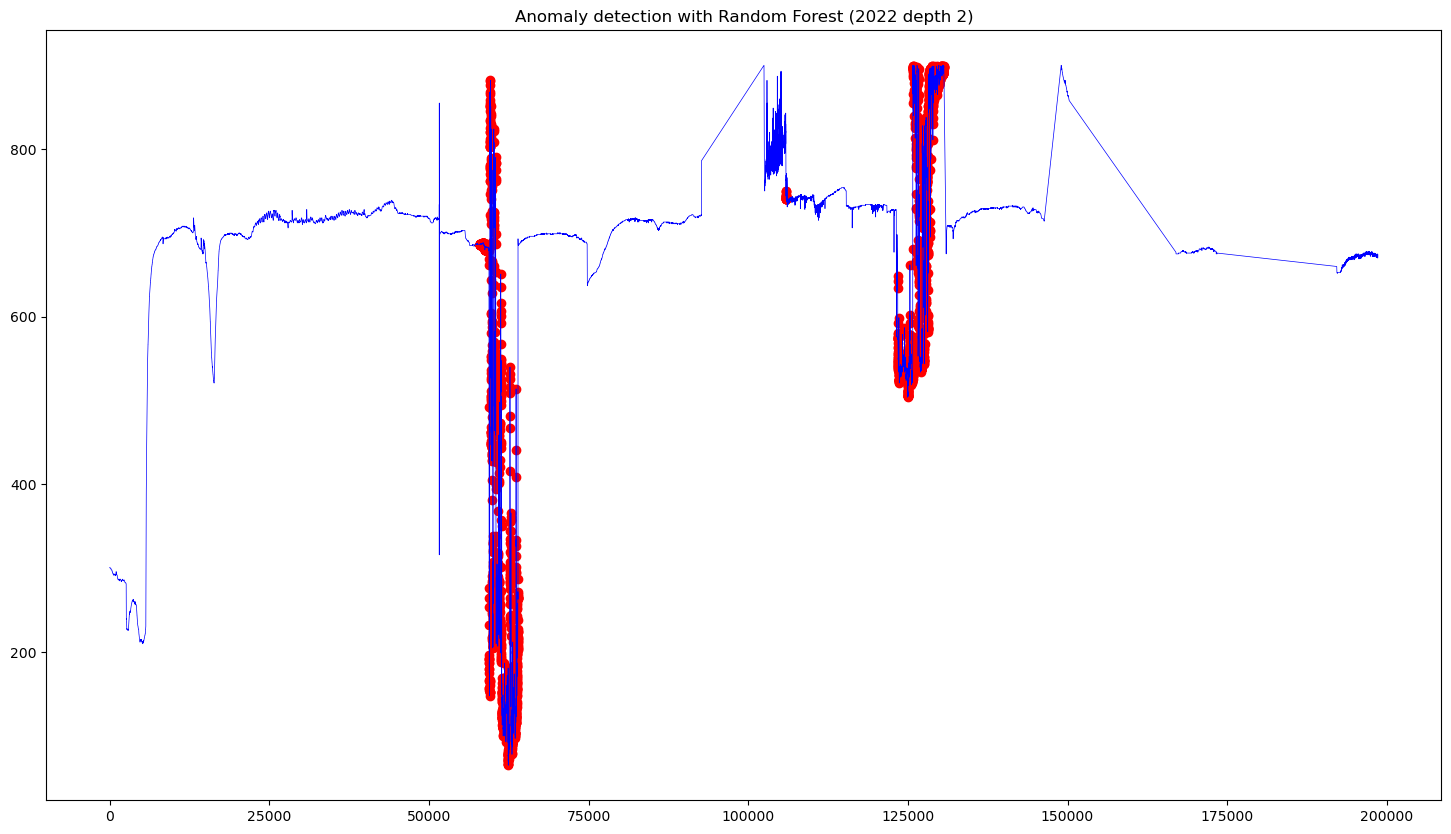

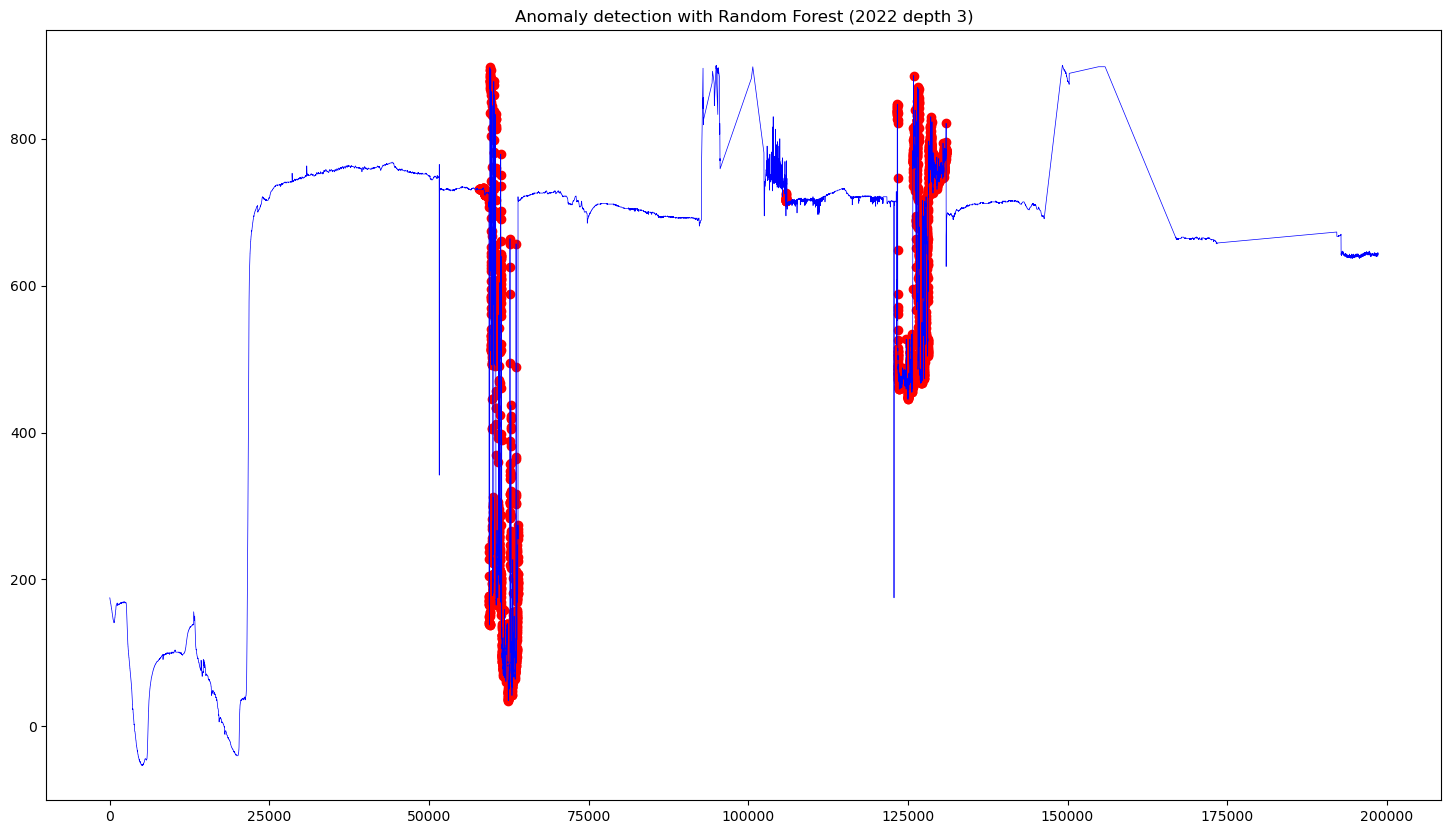

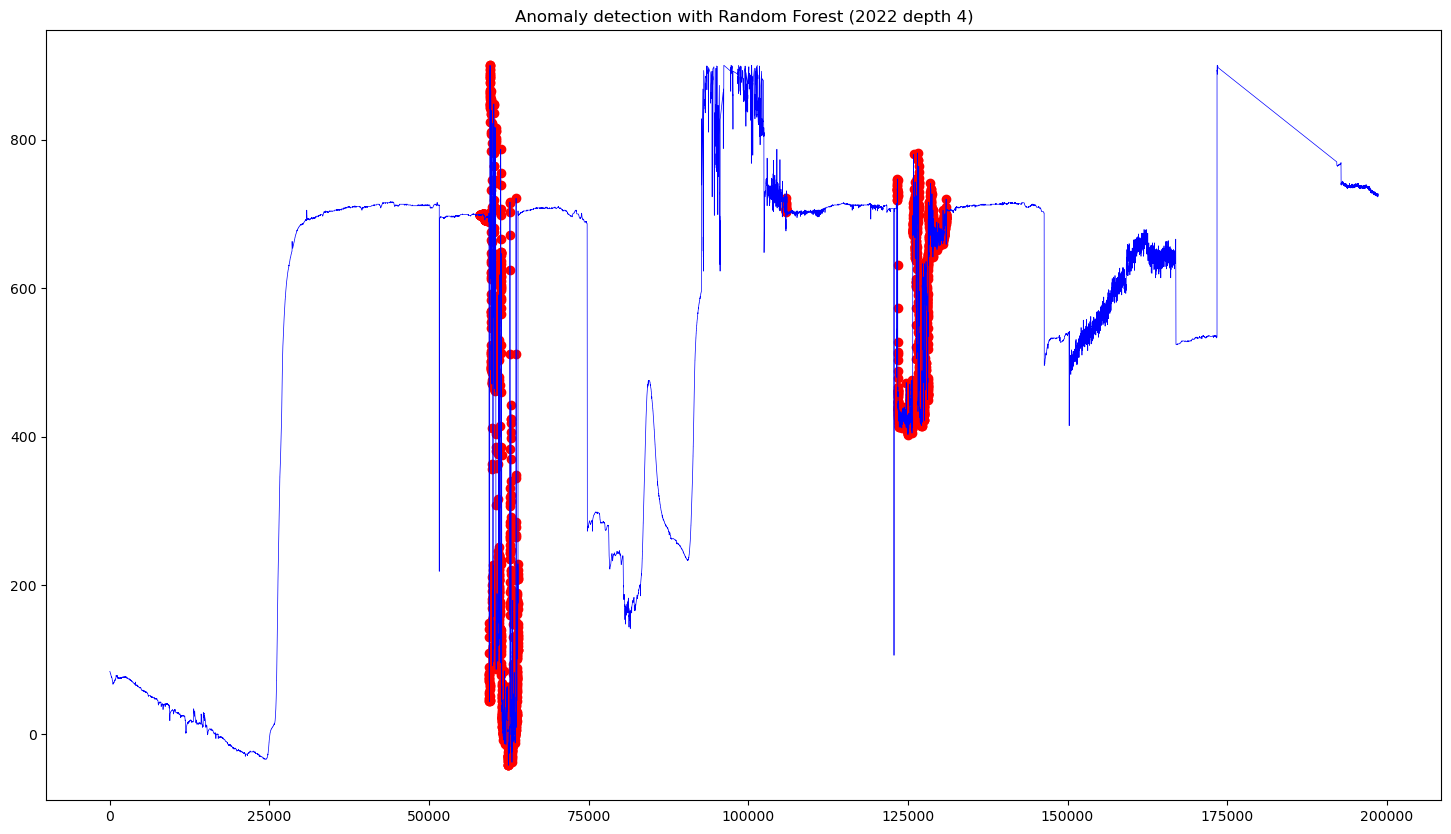

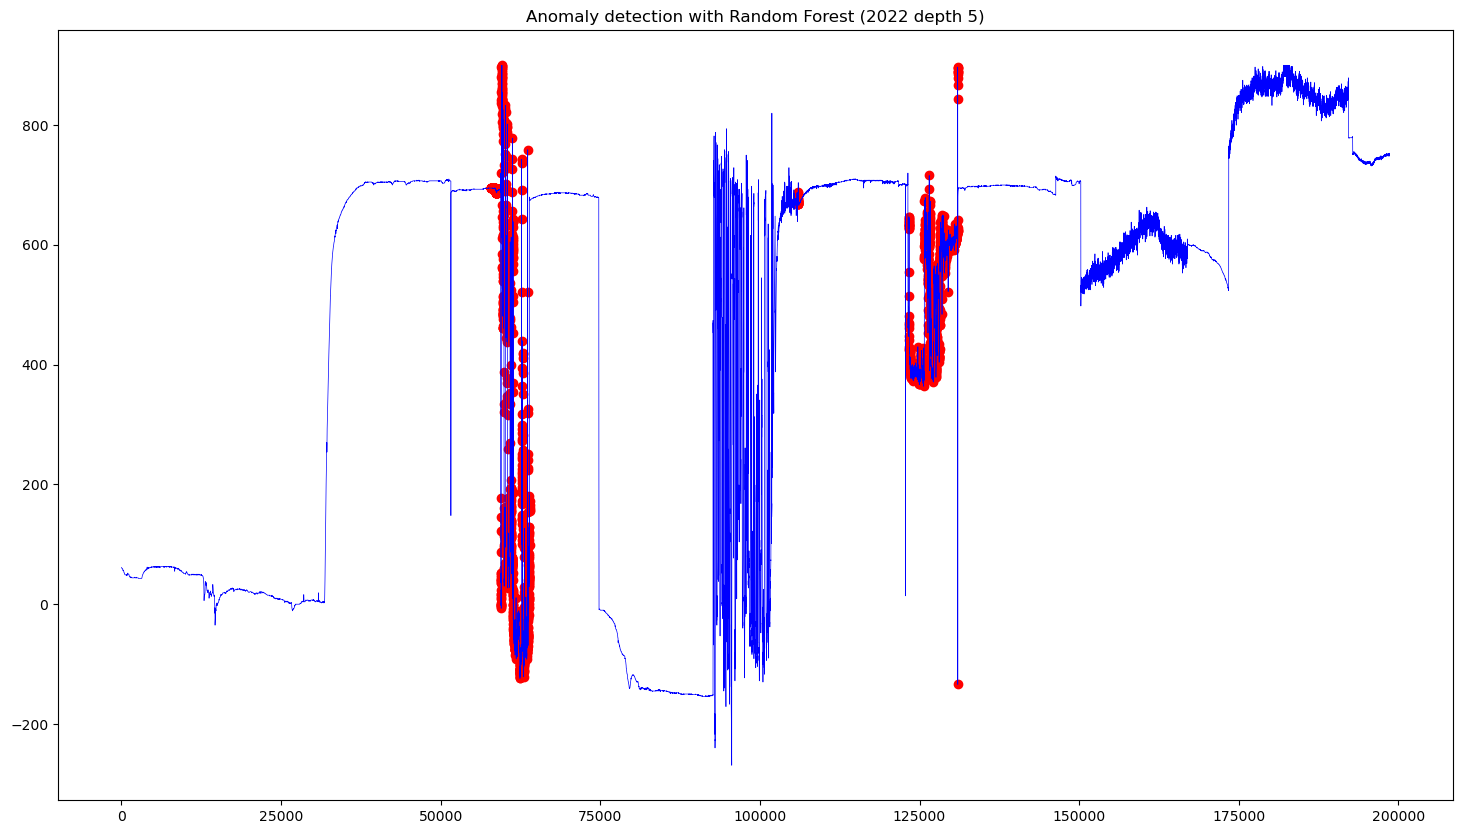

In [15]:
for d in range(1,6):
    rf.fit(filtered_pit_train_X[d-1], pit_train_y[d-1][f'Redox_error_flag({d})'])
    y_hat = rf.predict(filtered_pit_test_X[d-1])
    plt.figure(figsize=(18,10))
    plt.plot(pit_test_X[d-1].index, pit_test_X[d-1][f'Redox_Avg({d})'], linewidth=0.5, c='blue')
    plt.scatter(pit_test_X[d-1][y_hat == True].index, pit_test_X[d-1][y_hat == True][f'Redox_Avg({d})'], c='r')
    plt.title(f'Anomaly detection with Random Forest (2022 depth {d})')
    plt.show()

### 2023 sensor-specific predictions

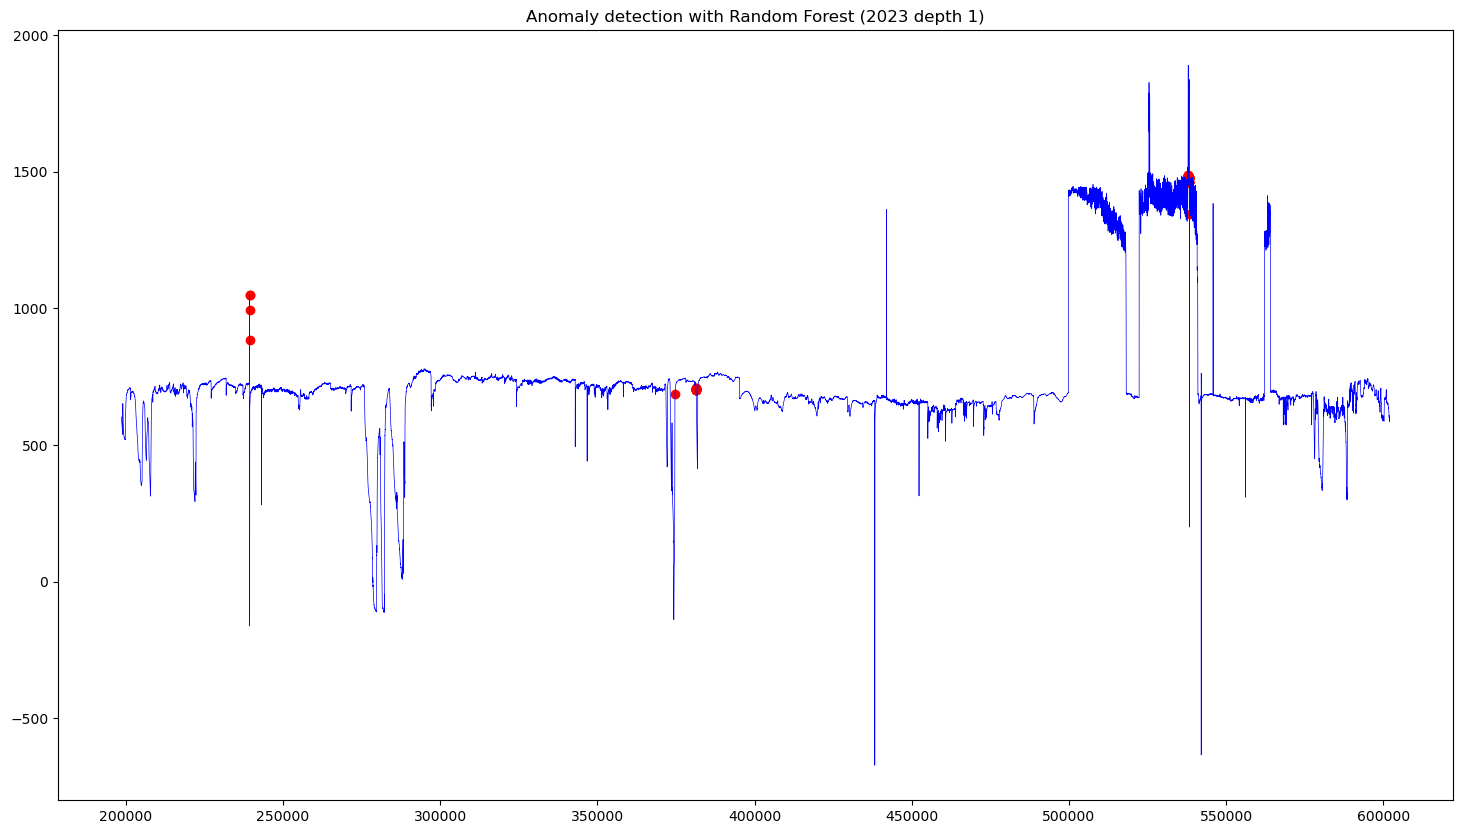

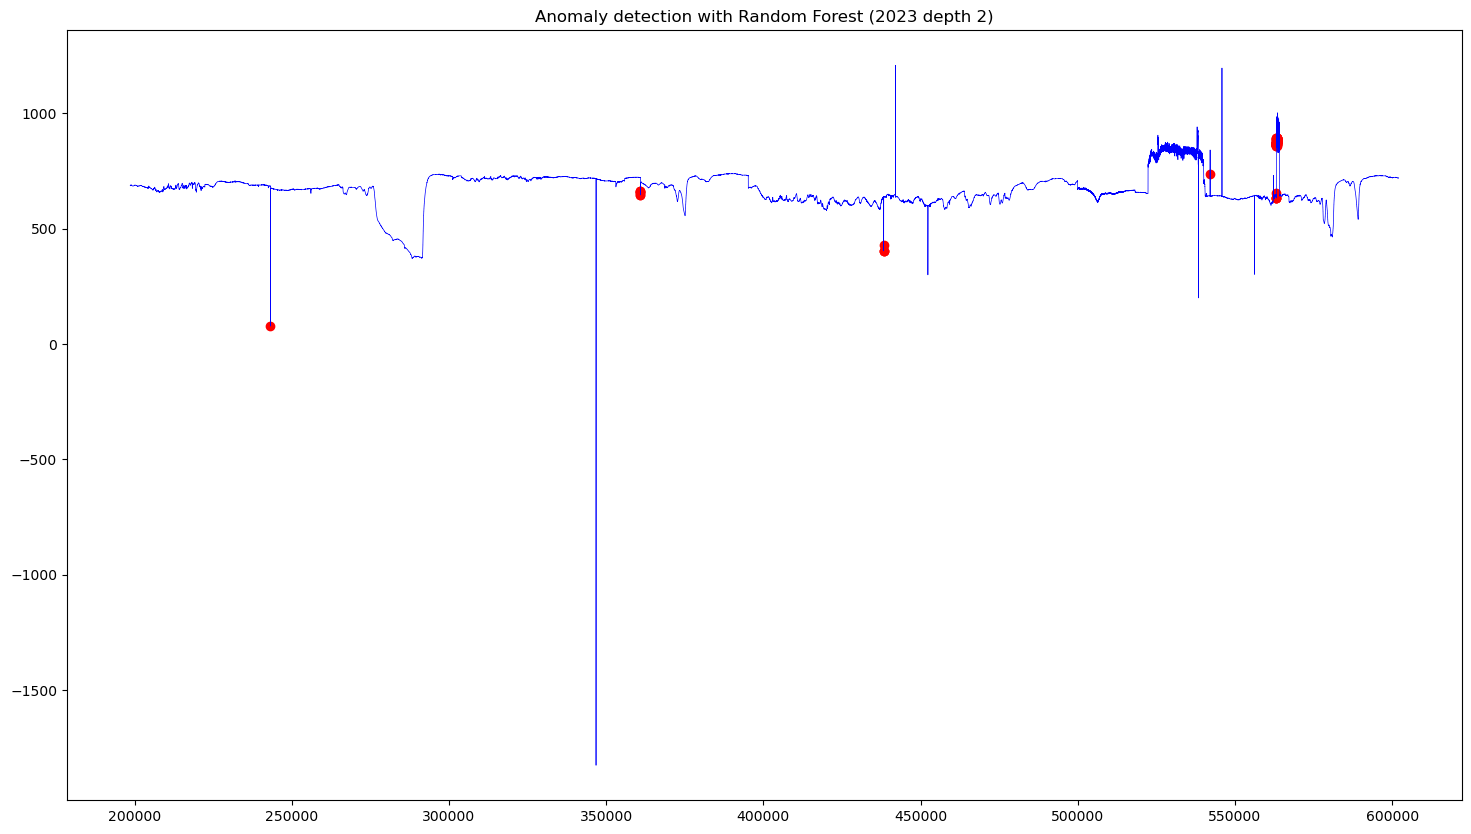

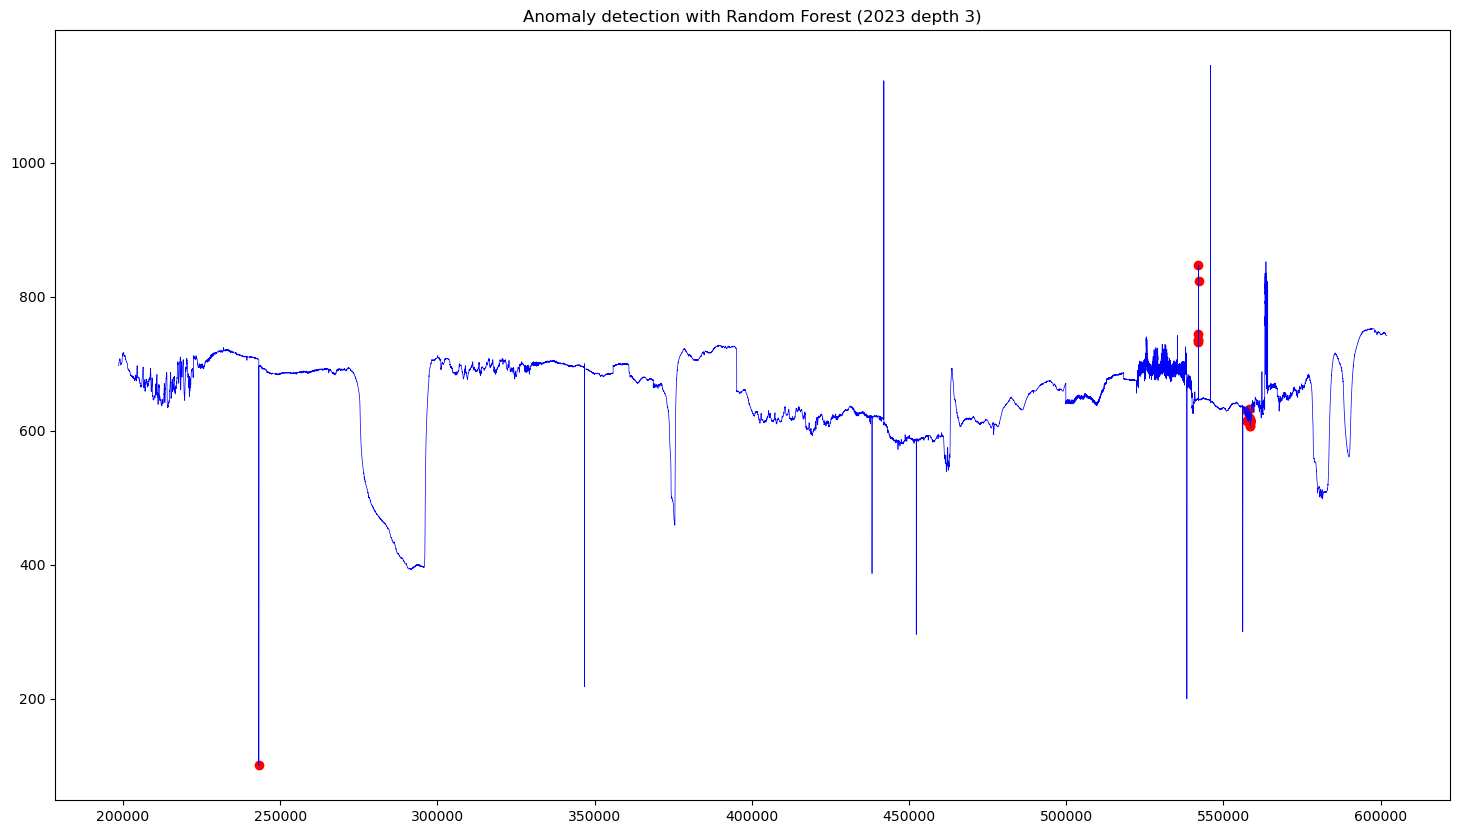

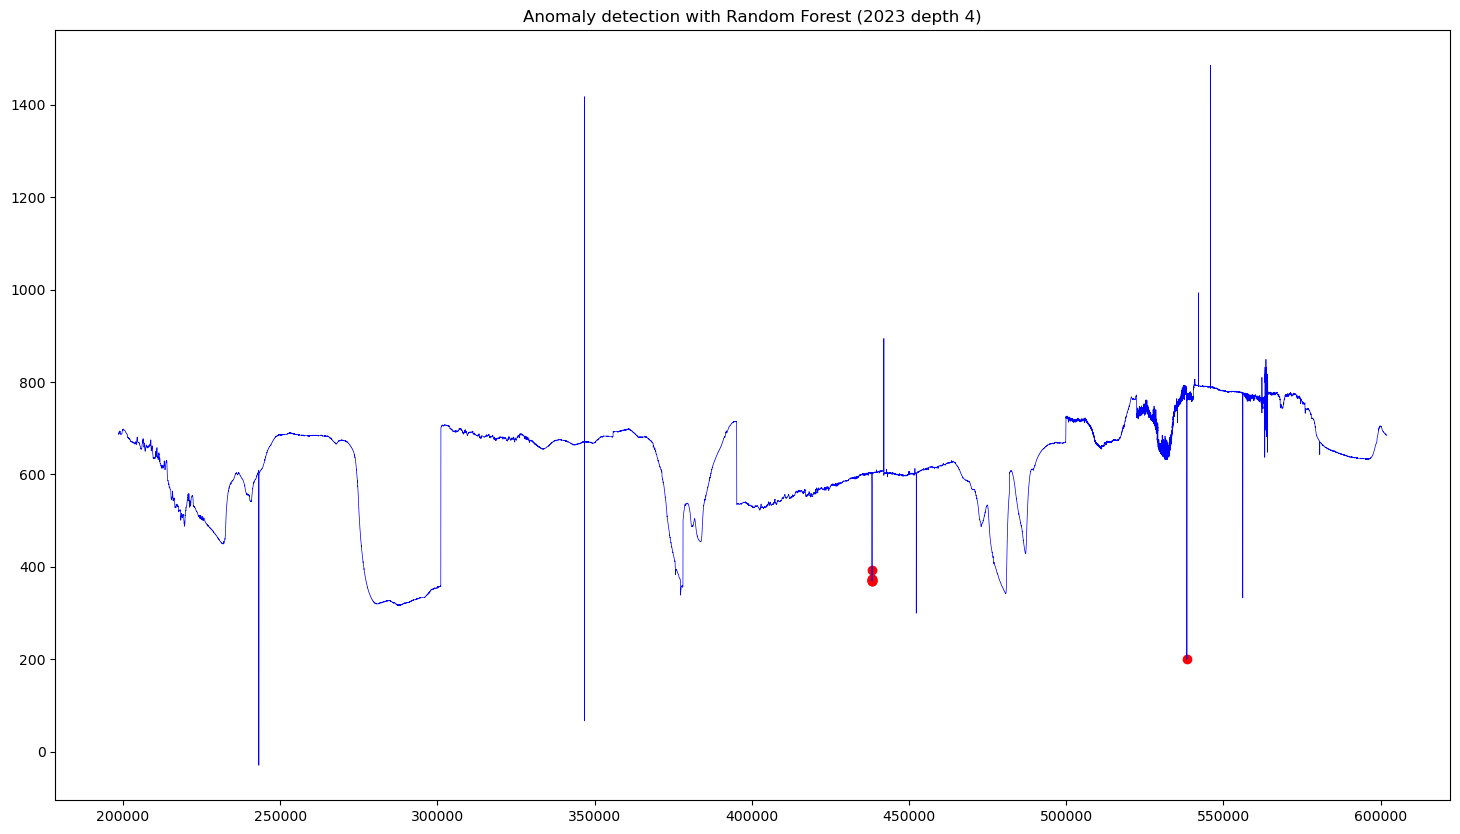

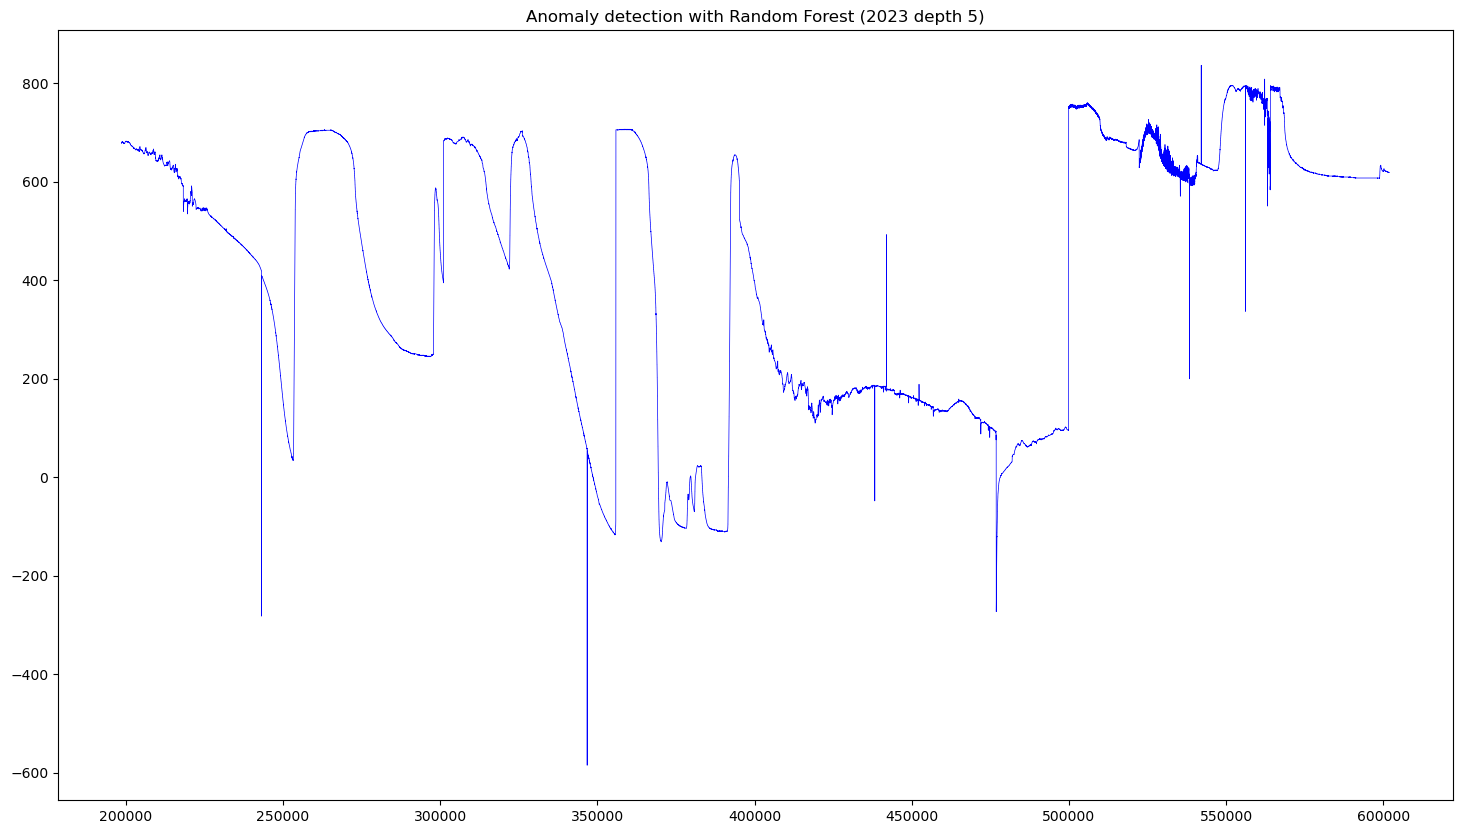

In [16]:
for d in range(1,6):
    rf.fit(filtered_pit_train_X[d-1], pit_train_y[d-1][f'Redox_error_flag({d})'])
    y_hat = rf.predict(filtered_pit_test_2023[d-1])
    plt.figure(figsize=(18,10))
    plt.plot(pit_test_2023[d-1].index, pit_test_2023[d-1][f'Redox_Avg({d})'], linewidth=0.5, c='blue')
    plt.scatter(pit_test_2023[d-1][y_hat == True].index, pit_test_2023[d-1][y_hat == True][f'Redox_Avg({d})'], c='r')
    plt.title(f'Anomaly detection with Random Forest (2023 depth {d})')
    plt.show()